In [1]:
import pycaret
from pycaret.classification import *

pycaret.__version__

'3.1.0'

In [2]:
import pandas as pd
import datetime
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [3]:
data_train = pd.read_parquet('../data/processed/train.gzip')
data_test = pd.read_parquet('../data/processed/test.gzip')
data_test_id = data_test[['ID']]

categorical_feats = ['CO_TIPO_SEXO', 'NO_DEPARTAMENTO']    # , 'ANIO_BANCARIZACION', 'MES_BANCARIZACION'
for col in categorical_feats:
    data_train[col] = data_train[col].astype('category')
    data_test[col] = data_test[col].astype('category')

TARGET_VAR = 'TARGET'
N_FOLDS = 5
N_JOBS = os.cpu_count() // 2.5

In [4]:
data_train.dtypes

ID                                      object
TARGET                                   int64
CO_TIPO_SEXO                          category
EDAD                                   float64
NO_DEPARTAMENTO                       category
                                        ...   
VAR_SALDO_TOTAL-VENCIDO_1_median       float64
VAR_SALDO_TOTAL-VENCIDO_MA3_mean       float64
VAR_SALDO_TOTAL-VENCIDO_MA3_median     float64
VAR_SALDO_TOTAL-VENCIDO_MA8_mean       float64
VAR_SALDO_TOTAL-VENCIDO_MA8_median     float64
Length: 141, dtype: object

In [5]:
# list(data_train.columns)
# data_train.isna().sum()

In [6]:
# get only numeric columns
data = data_train.select_dtypes(include=['int64', 'float64', 'category'])# pd.concat([data_train.select_dtypes(include=['int64', 'float64']), data_train['ID']], axis=1)
data = data.drop(columns=['EDAD'])
exclude_substr_list = ['MAX_LINEA_DISP_U6M', 'CANT_', '_max']       # 'VAR_', 'DIFF_', 
data = data[[col for col in data.columns if all([sub not in col for sub in exclude_substr_list])]]

data_test = data_test.select_dtypes(include=['int64', 'float64', 'category'])
data_test = data_test.drop(columns=['EDAD'])
data_test = data_test[[col for col in data_test.columns if all([sub not in col for sub in exclude_substr_list])]]

print(data.columns)
print(data_test.columns)

Index(['TARGET', 'CO_TIPO_SEXO', 'NO_DEPARTAMENTO', 'ANIO_BANCARIZACION',
       'MES_BANCARIZACION', 'SALDO_MED_EMP_mean', 'SALDO_MED_EMP_median',
       'SALDO_MED_EMP_last', 'SALDO_MED_EMP_min', 'SALDO_MED_EMP_first',
       'SALDO_PEQ_EMP_mean', 'SALDO_PEQ_EMP_median', 'SALDO_PEQ_EMP_last',
       'SALDO_PEQ_EMP_min', 'SALDO_PEQ_EMP_first', 'SALDO_MIC_EMP_mean',
       'SALDO_MIC_EMP_median', 'SALDO_MIC_EMP_last', 'SALDO_MIC_EMP_min',
       'SALDO_MIC_EMP_first', 'SALDO_CONS_REV_mean', 'SALDO_CONS_REV_median',
       'SALDO_CONS_REV_last', 'SALDO_CONS_REV_min', 'SALDO_CONS_REV_first',
       'SALDO_CONS_NO_REV_mean', 'SALDO_CONS_NO_REV_median',
       'SALDO_CONS_NO_REV_last', 'SALDO_CONS_NO_REV_min',
       'SALDO_CONS_NO_REV_first', 'SALDO_HIPOT_mean', 'SALDO_HIPOT_median',
       'SALDO_HIPOT_last', 'SALDO_HIPOT_min', 'SALDO_HIPOT_first',
       'SALDO_VENCIDO_mean', 'SALDO_VENCIDO_median', 'SALDO_VENCIDO_last',
       'SALDO_VENCIDO_min', 'SALDO_VENCIDO_first', 'SALDO_DOLA_NEG

In [7]:
# perform min max normalization in all columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.copy()

# data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
# data_scaled[TARGET_VAR] = data_train[TARGET_VAR]

In [8]:
# from imblearn.under_sampling import RepeatedEditedNearestNeighbours

# renn = RepeatedEditedNearestNeighbours(kind_sel='all')
# X, y = renn.fit_resample(data_scaled.drop(columns=[TARGET_VAR]), data_scaled[TARGET_VAR])

In [9]:
# data_scaled = pd.concat([X, y], axis=1)

data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [10]:
# variable selection with PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# data_pca = pca.fit_transform(data_scaled.drop(TARGET_VAR, axis=1))
# data_pca = pd.DataFrame(data_pca)
# data_pca[TARGET_VAR] = data_scaled[TARGET_VAR]
# data_pca.head(36)

In [11]:
data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [12]:
s = setup(data_scaled, 
          target=TARGET_VAR, 
          session_id=123, 
          use_gpu=True, 
          fold=N_FOLDS, 
          n_jobs=N_JOBS, 
          categorical_features=categorical_feats)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(91183, 95)"
4,Transformed data shape,"(91183, 97)"
5,Transformed train set shape,"(63828, 97)"
6,Transformed test set shape,"(27355, 97)"
7,Numeric features,92
8,Categorical features,2
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

In [13]:
# models()

In [14]:
# from pycaret.classification import ClassificationExperiment
# exp = ClassificationExperiment()
# exp.setup(data_pca, target=TARGET_VAR, session_id=123, use_gpu=True)
# exp.compare_models()

In [15]:
# add F1 macro to metrics
from sklearn.metrics import f1_score, make_scorer

try:
    def f1_macro(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    add_metric('f1_macro', 'F1 Macro', f1_macro, greater_is_better=True)
except:
    pass

In [16]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f57fa819090>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7f57fa8191b0>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7f57fa8192d0>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f1_macro,F1 Macro,F1 Macro,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f1_macro),pred,{},True,True,True


In [17]:
# all_models = models()
# all_models

# for model_id, model_name in all_models.items():
#     print(f"Model ID: {model_id}, Model Name: {model_name}")

In [18]:
best = compare_models(sort='Recall', exclude=['knn', 'svm', 'rbfsvm', 'dummy', 'lda', 'nb', 'ridge', 'qda', 'gpc', 'et'], fold=N_FOLDS)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:45:21
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.8003,0.6263,0.3765,0.3472,0.3612,0.2431,0.2434,0.6214,4.9020
catboost,CatBoost Classifier,0.8761,0.8274,0.2947,0.7091,0.4164,0.3600,0.4037,0.6735,4.6840
ada,Ada Boost Classifier,0.8707,0.8121,0.2719,0.6705,0.3868,0.3287,0.3709,0.6573,13.0640
gbc,Gradient Boosting Classifier,0.8747,0.8209,0.2676,0.7219,0.3904,0.3366,0.3886,0.6603,61.1720
lr,Logistic Regression,0.8570,0.7433,0.0945,0.6647,0.1654,0.1331,0.2126,0.5436,11.1600


In [31]:
# best_catboost_model = best[best['Algorithm'] == 'CatBoost']
# print(best_catboost_model)

TypeError: 'DecisionTreeClassifier' object is not subscriptable

In [19]:
# tuned_model = tune_model(best, optimize='F1 Macro')

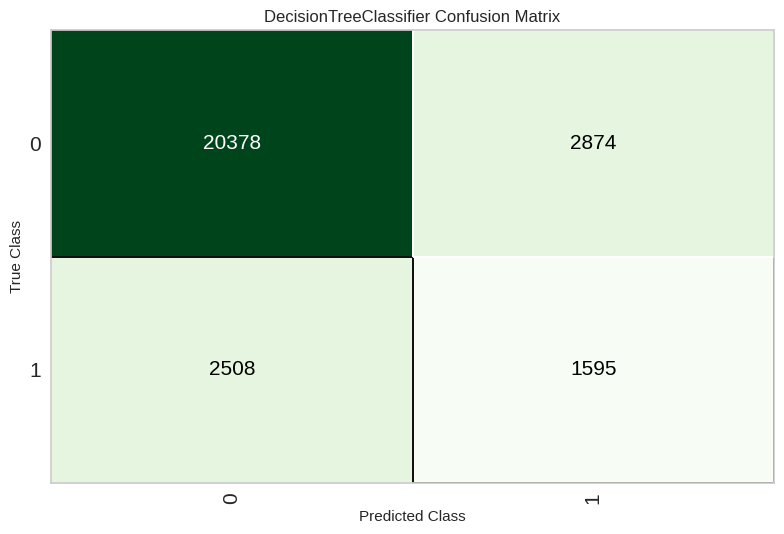

In [20]:
plot_model(best, plot='confusion_matrix')

In [21]:
# plot_model(best, plot='learning')

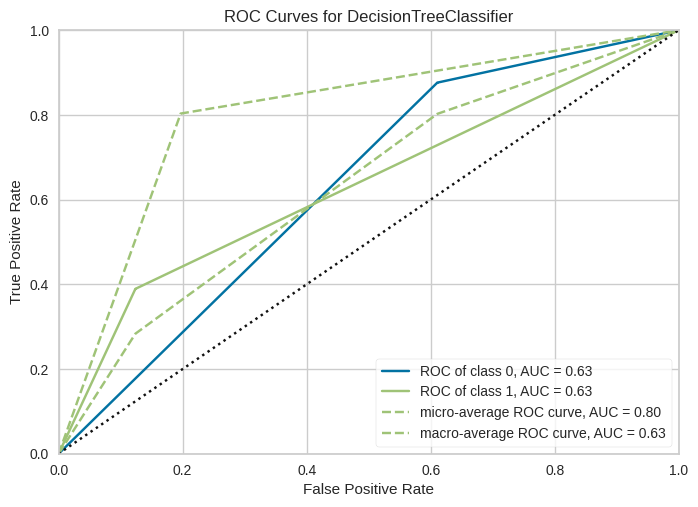

In [22]:
plot_model(best, plot='auc')

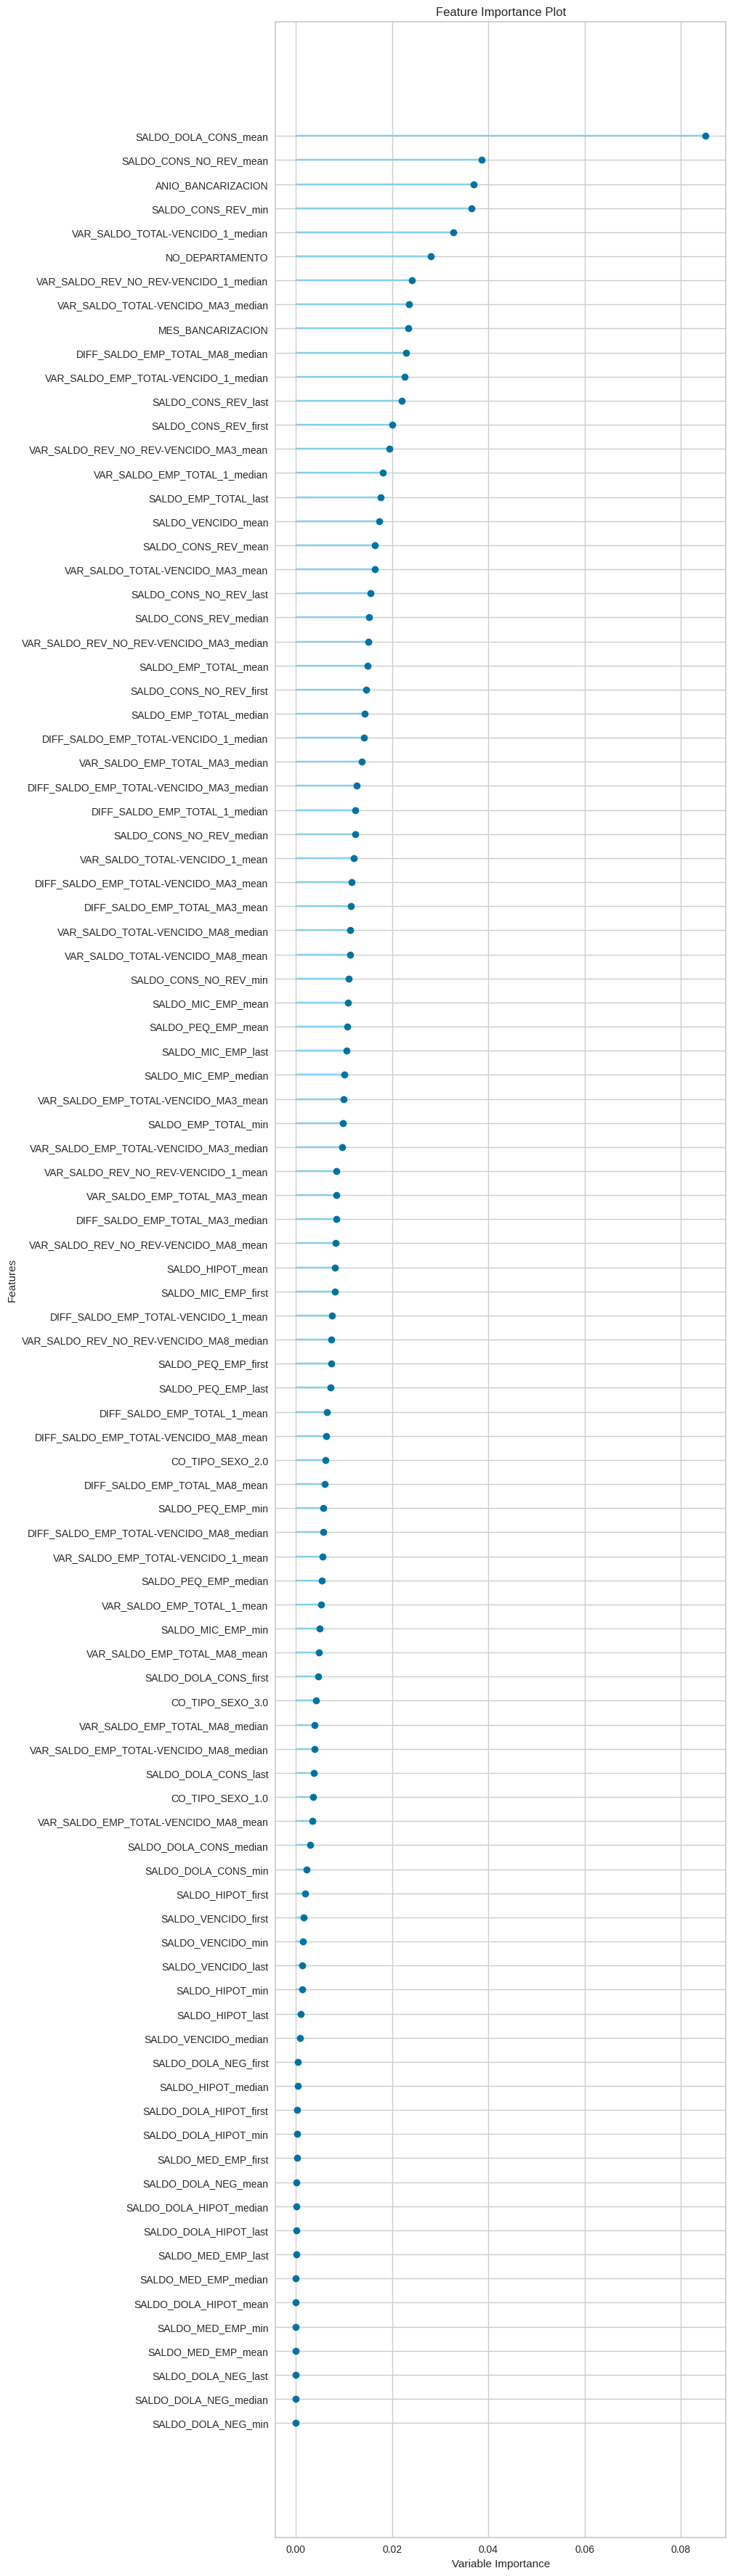

In [23]:
try:
    plot_model(best, plot='feature_all')
except:
    pass

In [24]:
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Decision Tree Classifier,0.8033,0.6327,0.3887,0.3569,0.3721,0.2557,0.2561,0.6277


In [25]:
predictions_train = predict_model(best, data=data_scaled)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Decision Tree Classifier,0.9408,0.8899,0.8152,0.7951,0.8050,0.7701,0.7702,0.8850


In [26]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(predictions_train[TARGET_VAR], predictions_train['prediction_label'], normalize='true')
cm = pd.DataFrame(cm, columns=['0', '1'])
cm.index = ['0', '1']
display(cm)

print(classification_report(predictions_train[TARGET_VAR], predictions_train['prediction_label']))

,0,1
0,0.962919,0.037081
1,0.184822,0.815178


              precision    recall  f1-score   support

           0       0.97      0.96      0.97     77505
           1       0.80      0.82      0.80     13678

    accuracy                           0.94     91183
   macro avg       0.88      0.89      0.89     91183
weighted avg       0.94      0.94      0.94     91183



In [27]:
predictions = predict_model(best, data=data_test.drop(columns=[TARGET_VAR]))

In [28]:
predictions['prediction_label'].value_counts(normalize=True)

0   0.837092
1   0.162908
Name: prediction_label, dtype: float64

In [29]:
now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

In [30]:
pd.concat([data_test_id, predictions[['prediction_label']]], axis=1).rename(columns={'prediction_label': TARGET_VAR}).to_csv(f'../data/results/submission_{now}.csv', index=False)  # , 'prediction_score'